In [114]:
import umap
import math
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.decomposition import DictionaryLearning
from scipy.stats import binom_test

import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_predict

from contrastive.evaluation.train_multiple_classifiers import compute_auc

In [115]:
# test model
test_model = "/neurospin/dico/jchavas/Runs/57_miccai2023_checks_done_after/Output/contrastive/trained_on_UkBioBank/chosen_model/chosen_model"
# test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/beta-VAE/n_10/#2"
dataset_train = 'cingulate_HCP_half_2'

# load the data
train_df = pd.read_csv(test_model+'/'+dataset_train+'_embeddings/train_val_embeddings.csv', index_col=0)
train_df.sort_index(inplace=True)

In [116]:
dataset_test = 'cingulate_HCP_full_gender'

test_df = pd.read_csv(test_model+'/'+dataset_test+'_embeddings/cross_val_effective_embeddings.csv', index_col=0)
test_df.sort_index(inplace=True)

# load the labels
prediction_df = pd.read_csv(test_model+'/'+dataset_test+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
prediction_df.sort_index(inplace=True)
len(prediction_df)

1113

In [117]:
prediction_df.head()

,label,svm_0,svm_1,svm_2,svm_3,svm_4,svm_5,svm_6,svm_7,svm_8,...,svm_243,svm_244,svm_245,svm_246,svm_247,svm_248,svm_249,median_pred,mean_pred,average_model
Subject,,,,,,,,,,,,,,,,,,,,,
100206,1,0.474709,0.474708,0.493886,0.450757,0.489558,0.500000,0.513143,0.526475,0.420391,...,0.469076,0.500000,0.469296,0.452190,0.426267,0.487383,0.479668,0.467337,0.467014,0.527357
100307,0,0.460536,0.461312,0.466158,0.453866,0.465159,0.466529,0.470637,0.472467,0.444554,...,0.459169,0.467451,0.458523,0.454183,0.445970,0.462797,0.461517,0.458245,0.458219,0.474587
100408,1,0.431705,0.434038,0.410333,0.460277,0.415904,0.404890,0.386118,0.366348,0.500000,...,0.438949,0.395955,0.436554,0.458287,0.487190,0.413233,0.424718,0.440017,0.440895,0.370531
100610,1,0.486163,0.485532,0.516259,0.448258,0.509257,0.521988,0.547311,0.569782,0.401361,...,0.477078,0.532051,0.478001,0.450588,0.410662,0.507244,0.494337,0.474828,0.474166,0.569665
101006,0,0.453256,0.454430,0.451948,0.455472,0.452649,0.450802,0.448876,0.444837,0.457190,...,0.454075,0.449135,0.452986,0.455211,0.456242,0.450199,0.452204,0.454139,0.453746,0.447562


## correlation functions

In [118]:
def get_model_by_quality(labels_df, q=0.5):
    aucs = labels_df.apply(compute_auc, args=[labels_df.label])
    aucs = aucs[aucs.index != 'label']
    model_auc = aucs.quantile(q=q, interpolation='nearest')
    aucs = aucs[aucs == model_auc]
    return(aucs.index[0], model_auc)

In [119]:
def cross_correlation(model_path, dataset='cingulate_ACCpatterns_1'):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    fig, axs = plt.subplots(1, 4, figsize=(30,10)) 

    latent_df = full_df.iloc[:,1:]
    corr = latent_df.corr()
    axs[0] = sns.heatmap(
            corr, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[0]
            )

    latent_df = full_df[full_df.label == 0].iloc[:,1:]
    corr0 = latent_df.corr()
    axs[1] = sns.heatmap(
            corr0, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[1]
            )

    latent_df = full_df[full_df.label == 1].iloc[:,1:]
    corr1 = latent_df.corr()
    axs[2] = sns.heatmap(
            corr1, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[2]
            )

    corrdiff = (corr1-corr0)
    axs[3] = sns.heatmap(
            corrdiff, 
            vmin=corrdiff.min().min(), vmax=corrdiff.max().max(), center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[3]
            )


In [120]:
def visualize_each_variable(model_path, display: str, display_err: bool, normalize=True, verbose=False, dataset='cingulate_ACCpatterns_1'):
    '''
    display: str -> takes the values '0', '1', 'all'
    '''
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Chooses to display only labels '0', '1' or all
    if display == '0':
        full_df = full_df[full_df.label == 0]
    elif display == '1':
        full_df = full_df[full_df.label == 1]
    
    # Some prints if verbose true
    if verbose:
        print("Prediction df:")
        print(prediction_df.iloc[:2, :2])
        print(len(prediction_df))
        print(prediction_df[['label']].shape)
        print("Data df:")
        print(len(data_df))
        print(data_df.iloc[:2, :2])
        print(data_df.shape)
        print("Full df:")
        print(len(full_df))
        print(full_df.iloc[:2, :2])
        print(full_df.shape)

    N, D = full_df.shape
    D = D-1 # There is the label column added

    # Initializes plot
    plt.figure(figsize=(16,12))

    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, N, axis=0)

    # Replaces labels 0, 1 with colors
    label_df = full_df[['label']].copy()
    label_df['label'] = label_df['label'].astype("str")
    label_df['label'] = label_df['label'].replace('0', 'b')
    label_df['label'] = label_df['label'].replace('1', 'r')

    # Builds colors to match pyplot requirements
    colors = label_df['label'].values
    colors = np.reshape(colors, (1,N))
    colors = np.repeat(colors, D, axis=0)
    colors = colors.T
    print('x, full_df and colors shapes: ', x.shape, full_df.shape, colors.shape)
    colors = np.reshape(colors, (N*D,))

    # latent (doesn't take the first column, which is the label)
    latent_df = full_df.iloc[:,1:]
    mu = latent_df.mean()
    std = latent_df.std()
    if normalize == True:
        latent_df = (latent_df-mu)/std

    # Actual plotting of each point
    plt.scatter(x, latent_df, c=colors, marker='.')

    # Computes averages
    if display == "all":
        # Computes average for label=0
        x = np.arange(D)
        label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
        if normalize == True:   
            label0_df = (label0_df-mu)/std
        mean_df = label0_df.mean()
        e_df = label0_df.std()
        print(x.shape, mean_df.shape, e_df.shape)
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='blue', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3, solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

        # Computes average for label=1
        label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
        if normalize == True:   
            label1_df = (label1_df-mu)/std
        mean_df = label1_df.mean()
        e_df = label1_df.std()
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='red', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3,solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    # Shows the computed plot
    plt.show()

    return 

In [121]:
def full_visualization(model_path, dataset='cingulate_ACCpatterns_1'):
    plt.figure(figsize=(12.8, 9.6))
    fig = plt.imshow(mpimg.imread(model_path+"/"+dataset+"_embeddings/cross_val_ROC_curves.png"))
    plt.axis('off')
    plt.show()
    return visualize_umaps(model_path, dataset)

In [122]:
# test model
# visual_embs = full_visualization(test_model)

## Visualize each variable of the latent

x, full_df and colors shapes:  (171, 10) (171, 11) (171, 10)
(10,) (10,) (10,)


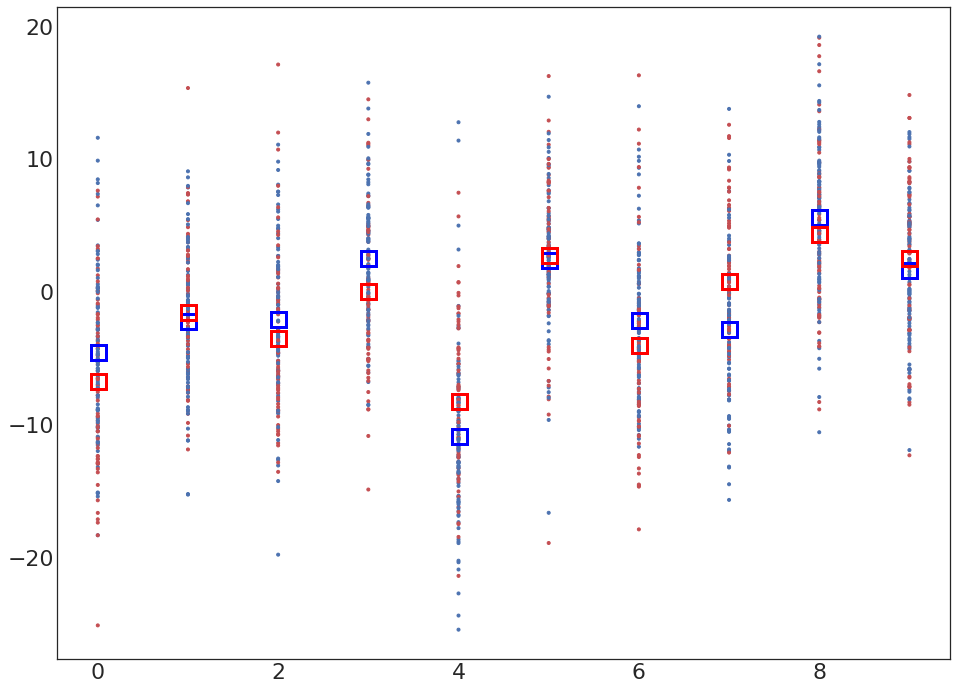

In [123]:
visualize_each_variable(test_model, display='all', display_err=False, normalize=False, verbose=False)

In [124]:
def do_pca(model_path, dataset=dataset_test):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Makes PCA over all dataframe
    latent_df = full_df.iloc[:,1:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    n_components = latent_df.shape[1]
    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(latent_df_normalized)

    # Transforms over label0 dataframe
    label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
    label0_df = (label0_df - latent_df.mean()) / latent_df.std()
    transformed0 = pca.transform(label0_df)
    mean0 = np.mean(transformed0, axis=0)
    print(mean0.shape)

    # Transforms over label1 dataframe
    label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
    label1_df = (label1_df - latent_df.mean()) / latent_df.std()
    transformed1 = pca.transform(label1_df)
    mean1 = np.mean(transformed1, axis=0)
    print(mean1.shape)

    idx = np.arange(n_components)+1
    explained_variance = pca.explained_variance_ratio_
    cum_explained_variance = np.cumsum(explained_variance)
    df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx).T

    limit_df = n_components

    #make scree plot
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    fig, axs = plt.subplots(1, 2, figsize=(30,10)) 
    [t.set_color('white') for t in axs[0].xaxis.get_ticklabels()]
    [t.set_color('white') for t in axs[0].yaxis.get_ticklabels()]
    axs[0].set_title('Explained variance across principal components', fontsize=14)
    axs[0].set_xlabel('Principal component', fontsize=12)
    axs[0].set_ylabel('Explained variance', fontsize=12)
    sns.barplot(ax=axs[0], x=idx[:limit_df], y='explained variance', data=df_explained_variance, palette='summer')
    axs[0] = axs[0].twinx()
    axs[0].grid(False)
    axs[0].set_ylabel('Cumulative', fontsize=14)
    sns.lineplot(ax=axs[0], x=idx[:limit_df]-1, y='cumulative', data=df_explained_variance, color='#fc8d59')

    N, D = transformed.shape
    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed0.shape[0], axis=0)
    axs[1].scatter(x, transformed0, c='blue', marker='.')
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed1.shape[0], axis=0)
    axs[1].scatter(x, transformed1, c='red', marker='.')
    x = np.arange(D)
    axs[1].plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)
    axs[1].plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    plt.show()


In [125]:
def do_dictionary_learning(data_df, n_components=10, transform_n_nonzero_coefs=1):
    data_df_local = data_df.copy()
    full_df_local = pd.DataFrame()
    # Makes dictionary learning over all embeddings
    latent_df = data_df_local.iloc[:,:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    n_components = n_components
    dict_learner = DictionaryLearning(n_components=n_components,
                                      transform_n_nonzero_coefs=transform_n_nonzero_coefs,
                                      alpha=1)
    transformed = dict_learner.fit_transform(latent_df_normalized)

    # Adds transform to full_df
    columns = ['trans_'+str(x) for x in range(n_components)]
    transformed_df_local = pd.DataFrame(transformed, columns=columns)
    transformed_df_local.index = data_df_local.index
    full_df_local = pd.merge(data_df_local, transformed_df_local, left_index=True, right_index=True)

    return full_df_local, transformed_df_local, dict_learner

In [126]:
def plot_patterns(prediction_df, transformed_df, random=False):
    # Makes local copy
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    if random:
        prediction_df_local['label'] = np.random.permutation(prediction_df_local['label'].values)
    full_df_local = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Transforms over label0 dataframe
    label0_df = full_df_local[full_df_local['label'] == 0].iloc[:,1:]
    transformed0 = label0_df.values

    # Transforms over label1 dataframe
    label1_df = full_df_local[full_df_local['label'] == 1].iloc[:,1:]
    transformed1 = label1_df.values

    fig, axs = plt.subplots(1, 1, figsize=(10,7)) 

    _, D = transformed0.shape

    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed0.shape[0], axis=0)
    axs.scatter(x, transformed0, c='blue', marker='.')
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed1.shape[0], axis=0)
    axs.scatter(x, transformed1, c='red', marker='.')

    x = np.arange(D)

    masked0 = np.ma.masked_equal(transformed0, 0.)
    mean0 = masked0.mean(axis=0)
    axs.plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    masked1 = np.ma.masked_equal(transformed1, 0.)
    mean1 = masked1.mean(axis=0)
    axs.plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    plt.show()

In [170]:
def return_predictions(prediction_df, transformed_df, random=False):
    # Initializes
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    res = np.zeros(2*n_patterns)

    # Makes random permutation to produce random label
    if random:
        prediction_df_local['label'] = np.random.permutation(prediction_df_local['label'].values)

    full_df_local = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Makes prediction for each pattern
    for i, c in enumerate(transformed_df_local.columns):
        df = full_df_local[full_df_local[c] < 0.]
        res[2*i] = df['label'].mean()
        df = full_df_local[full_df_local[c] > 0.]
        res[2*i+1] = df['label'].mean()

    return res

def plot_predictions(prediction_df, transformed_df):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    x = np.arange(2*n_patterns)
    res_random = np.zeros((20, 2*n_patterns))

    # Loads labels
    mean_label = prediction_df_local['label'].mean()
    print(f"Mean label = {mean_label}")

    # Computes pattern prediction
    res = return_predictions(prediction_df_local, transformed_df_local)
    for i in range(20):
        res_random[i,:] = return_predictions(prediction_df_local, transformed_df_local, True)
    
    for i in range(20):
        plt.scatter(x, res_random[i], c='grey')

    plt.scatter(x, res, c='red')
    plt.plot(mean_label*np.ones(2*n_patterns))
    plt.ylim((0,1))
    return res   

In [171]:
def return_sum(prediction_df, transformed_df, random=False):
    # Initializes
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    res_sum = np.zeros(2*n_patterns)
    res_len = np.zeros(2*n_patterns)

    full_df = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Makes prediction for each pattern
    for i, c in enumerate(transformed_df_local.columns):
        df = full_df[full_df[c] < 0.]
        res_sum[2*i] = df['label'].sum()
        res_len[2*i] = len(df)
        df = full_df[full_df[c] > 0.]
        res_sum[2*i+1] = df['label'].sum()
        res_len[2*i+1] = len(df)

    return res_sum, res_len


def do_t_test(prediction_df, transformed_df, show=True, nb_components=10):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    x = np.arange(2*n_patterns)
    res_p = np.zeros(2*n_patterns)

    # Mean labels
    mean_label = prediction_df_local['label'].mean()
    # print(f"Mean label = {mean_label}")

    # Computes pattern prediction
    res_sum, res_len = return_sum(prediction_df_local, transformed_df_local)
    print(res_len)
    
    for i in range(2*n_patterns):
        res_p[i] = binom_test(res_sum[i], n=res_len[i], p=mean_label, alternative='two-sided')

    if show:
        plt.scatter(x, -np.log10(res_p))
        plt.plot(-np.log10(0.05/(2*nb_components))*np.ones(2*n_patterns))

    return res_p   

In [172]:
def give_number_relevant_subjects_accuracy(prediction_df, transformed_df, res_p, show=True, nb_components=10):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    df = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)
    nb_subjects = np.zeros(len(res_p))
    nb_subjects_relevant = 0
    exact_nb_subjects_relevant = 0
    log_p_nb_subjects = 0
    max_auc_score = 0.0
    auc_score = np.zeros(len(res_p))
    accuracy = []
    # print(len(df.columns))
    for i in range(1,len(df.columns)):
        # print(df.iloc[:,[i]].columns)
        d = df[df.iloc[:,i] < 0.]
        d = d.copy()
        if 2.*d.label.sum() < (len(d.label)):
            d.iloc[:,i] = 0
        else:
            d.iloc[:,i] = 1
        # print(np.unique(d.label.values).shape)
        nb_subjects[2*i-2] = len(d)
        auc_score[2*i-2] = accuracy_score(d.label, d.iloc[:,i])
        if 2.*d.label.sum() < (len(d.label)):
            exact_nb_subjects = len(d.label)-d.label.sum()
        else:
            exact_nb_subjects = d.label.sum()
        accuracy.append(float(exact_nb_subjects)/len(d.label))
        
        if res_p[2*i-2] < 0.05/nb_components:
            nb_subjects_relevant += nb_subjects[2*i-2]
            max_auc_score = max(auc_score[2*i-2], max_auc_score)
            exact_nb_subjects_relevant += exact_nb_subjects
            log_p_nb_subjects += -np.log10(res_p[2*i-2])*exact_nb_subjects

        d = df[df.iloc[:,i] > 0.]
        d = d.copy()
        if 2.*d.label.sum() < (len(d.label)):
            d.iloc[:,i] = 0
        else:
            d.iloc[:,i] = 1
        nb_subjects[2*i-1] = len(d)
        auc_score[2*i-1] = accuracy_score(d.label, d.iloc[:,i])
        if 2.*d.label.sum() < (len(d.label)):
            exact_nb_subjects = len(d.label)-d.label.sum()
        else:
            exact_nb_subjects = d.label.sum()
        accuracy.append(float(exact_nb_subjects)/len(d.label))
        
        if res_p[2*i-1] < 0.05/nb_components:
            nb_subjects_relevant += nb_subjects[2*i-1]
            max_auc_score = max(auc_score[2*i-1], max_auc_score)
            exact_nb_subjects_relevant += exact_nb_subjects
            log_p_nb_subjects += -np.log10(res_p[2*i-2])*exact_nb_subjects
            
    # print(d)
    if show:
        x = np.arange(len(res_p))
        plt.scatter(x, auc_score)
        plt.ylabel('accuracy_score')
        # plt.scatter(res_p, auc_score)
        # plt.xlabel('p value')
        # plt.ylabel('auc_score')
    return accuracy, nb_subjects_relevant, max_auc_score, exact_nb_subjects_relevant, log_p_nb_subjects

In [173]:
def test_dictionary_learning(dict_learner, test_df, n_components):
    test_df_local = test_df.copy()
    full_df_local = pd.DataFrame()
    latent_df = test_df_local.iloc[:,:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    transformed = dict_learner.transform(latent_df_normalized)

    # Adds transform to full_df
    columns = ['trans_'+str(x) for x in range(n_components)]
    transformed_df_local = pd.DataFrame(transformed, columns=columns)
    transformed_df_local.index = test_df_local.index
    full_df_local = pd.merge(test_df_local, transformed_df_local, left_index=True, right_index=True)

    return full_df_local, transformed_df_local


## Non-zeros=1, nb_components=4

In [174]:
full_df, transformed_train_df, dict_learner = do_dictionary_learning(data_df=train_df, n_components=4, transform_n_nonzero_coefs=1)

In [175]:
full_df, transformed_df = test_dictionary_learning(dict_learner=dict_learner, test_df=test_df, n_components=4)

In [176]:
dict_learner.components_

array([[ 0.25346631, -0.23969648,  0.35706975,  0.21168939, -0.34679486,
        -0.29861129,  0.23691197,  0.05820267,  0.06706607, -0.65767861],
       [ 0.42719362,  0.34310376,  0.03113515,  0.15399993,  0.17868199,
        -0.22691016,  0.11849456, -0.67422534, -0.20136888,  0.28725317],
       [ 0.03489453, -0.16068579, -0.68386078,  0.2266208 , -0.17029625,
        -0.5585947 , -0.24544526,  0.17664338, -0.01289857,  0.14593971],
       [ 0.20280688, -0.52090497,  0.09046495,  0.13051579, -0.10044322,
         0.29268507, -0.49255801, -0.29633514, -0.48474914, -0.03385372]])

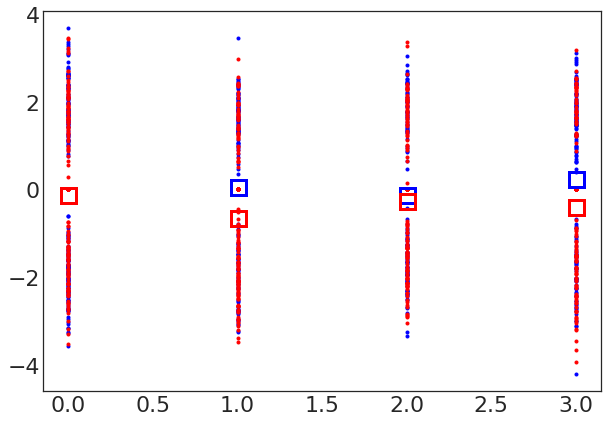

In [177]:
plot_patterns(prediction_df, transformed_df, random=False)

In [178]:
# plot_patterns(prediction_df, transformed_df, random=True)

In [213]:
def plot_patterns_separated(prediction_df, transformed_df, random=False):
    # Makes local copy
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    if random:
        prediction_df_local['label'] = np.random.permutation(prediction_df_local['label'].values)
    full_df_local = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    l = len(full_df_local)
    d = len(full_df_local.columns)
    res = pd.DataFrame(np.zeros((l,3)), index=full_df_local.index, columns=["val", "label", "pat"])
    patterns = ["Am", "Ap", "Bm", "Bp", "Cm", "Cp", "Dm", "Dp"]

    for index, row in transformed_df_local.iterrows():
        idx_nonzero = int(np.nonzero(row.values)[0])
        val_nonzero = row.iloc[idx_nonzero]
        res.loc[index, "val"] = np.abs(val_nonzero)
        res.loc[index, "label"] = prediction_df_local.loc[index, "label"]
        if val_nonzero < 0.:
            res.loc[index, "pat"] = patterns[2*idx_nonzero]
        else:
            res.loc[index, "pat"] = patterns[2*idx_nonzero+1]

    res.sort_values(ascending=True, by='pat', inplace=True)

    f, ax = plt.subplots(1, 1, figsize=(10, 5))
    # g = sns.pointplot(data=res, x=res.pat, y="val", hue = "label", alpha=[0.5,0.5], palette=['blue', 'red'], markers=['v', 's'], scale=2, linestyles=['None', 'None'], ax=ax)
    # plt.setp(g.collections, alpha=0.5)
    # plt.setp(g.lines, alpha=.5) 
    sns.stripplot(data=res[res.label==0], x=res.pat, y="val", hue = "label", marker='v', palette=['blue'], size=5, jitter=.3, ax=ax)
    sns.stripplot(data=res[res.label==1], x=res.pat, y="val", hue = "label", marker='s', palette=['red'], size=5, jitter=.3, ax=ax)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[1], handles[0]], ["male", "female"], labelspacing=2)

    plt.show()

    return res

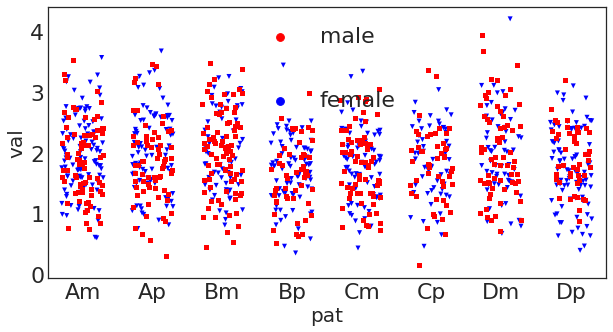

In [214]:
res_df = plot_patterns_separated(prediction_df, transformed_df)

In [215]:
res_df.head()

,val,label,pat
Subject,,,
996782,2.401550,0.0,Am
298051,2.690259,0.0,Am
295146,1.927362,0.0,Am
131924,2.584118,1.0,Am
286650,1.956918,1.0,Am


In [216]:
a = "ab"
a[0]

'a'

In [217]:
res_df2 = res_df.copy()
res_df2["atom"] = res_df2["pat"].apply(lambda x: x[0])
res_df2["sign"] = res_df2["pat"].apply(lambda x: x[1])
res_df2.rename(columns={"label": "gender"}, inplace=True)
res_df2.gender = res_df2.gender.apply(lambda x: "male" if x== 1.0 else "female")
# res_df2.sort_values(ascending=True, by='atom', inplace=True)
# res_df2.sort_values(ascending=False, by='sign', inplace=True)
res_df2 = res_df2.sort_values(['atom', 'sign'], ascending=[True, False])
res_df2.drop(columns="pat", inplace=True)

In [218]:
res_df2.head()

,val,gender,atom,sign
Subject,,,,
192136,1.387462,male,A,p
192540,1.122741,female,A,p
161731,2.544318,female,A,p
984472,1.437275,female,A,p
987074,1.590237,male,A,p


['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


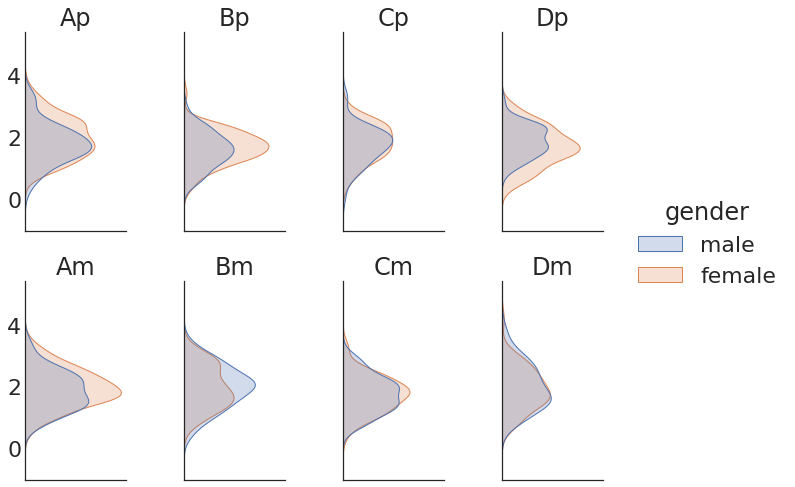

In [219]:
sns.set(font_scale=2)
print(plt.style.available)
plt.style.use('seaborn-white')
g = sns.displot(
    data=res_df2, y="val", hue="gender", col="atom", row="sign",
    fill=True,
    kind="kde", height=4, aspect=.6,
)
g.set_axis_labels("", "")
g.set_titles("{col_name}{row_name}", loc='center')
g.set(xticklabels=[])
# plt.setp(g._legend.get_title(), fontsize=30)

In [186]:
def plot_patterns_separated_without_labels(transformed_df, random=False):
    # Makes local copy
    transformed_df_local = transformed_df.copy()
    full_df_local = transformed_df_local

    l = len(full_df_local)
    d = len(full_df_local.columns)
    res = pd.DataFrame(np.zeros((l,3)), index=full_df_local.index, columns=["val", "label", "pat"])
    patterns = ["Ap", "Am", "Bp", "Bm", "Cp", "Cm", "Dp", "Dm"]

    for index, row in transformed_df_local.iterrows():
        idx_nonzero = int(np.nonzero(row.values)[0])
        val_nonzero = row.iloc[idx_nonzero]
        res.loc[index, "val"] = np.abs(val_nonzero)
        res.loc[index, "label"] = 0
        if val_nonzero > 0.:
            res.loc[index, "pat"] = patterns[2*idx_nonzero]
        else:
            res.loc[index, "pat"] = patterns[2*idx_nonzero+1]

    res.sort_values(ascending=True, by='pat', inplace=True)

    f, ax = plt.subplots(1, 1, figsize=(10, 5))
    g = sns.pointplot(data=res, x=res.pat, y="val", hue = "label", alpha=[0.5,0.5], palette=['blue', 'red'], markers=['v', 's'], scale=2, linestyles=['None', 'None'], ax=ax)
    plt.setp(g.collections, alpha=0.5)
    # plt.setp(g.lines, alpha=.5) 
    sns.stripplot(data=res[res.label==0], x=res.pat, y="val", hue = "label", marker='v', palette=['blue'], jitter=.1, ax=ax)
    # sns.stripplot(data=res[res.label==1], x=res.pat, y="val", hue = "label", marker='s', palette=['red'], jitter=.1, ax=ax)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([],[], frameon=False)
    
    plt.show()

    return res

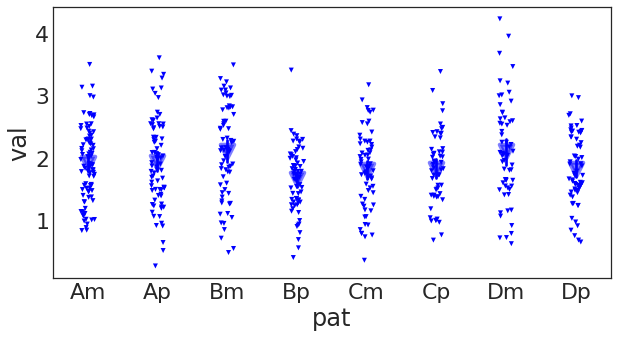

In [220]:
res_train_df = plot_patterns_separated_without_labels(transformed_train_df)

In [221]:
def plotting_hist(res_df):
    patterns = ["Ap", "Am", "Bp", "Bm", "Cp", "Cm", "Dp", "Dm"]

    plt.rc('axes', labelsize=14) 
    f, axs = plt.subplots(4, 2, figsize=(11, 22))

    for i, pat in enumerate(patterns):
        axs[i%4,int(i/4)].hist(res_df[(res_df.label==0) & (res_df.pat==pat)].val, alpha=0.5)
        axs[i%4,int(i/4)].hist(res_df[(res_df.label==1) & (res_df.pat==pat)].val, alpha=0.5)

In [222]:
# res0_df = res_df.copy()
# res0_df.label=0
# plotting_hist(res0_df)

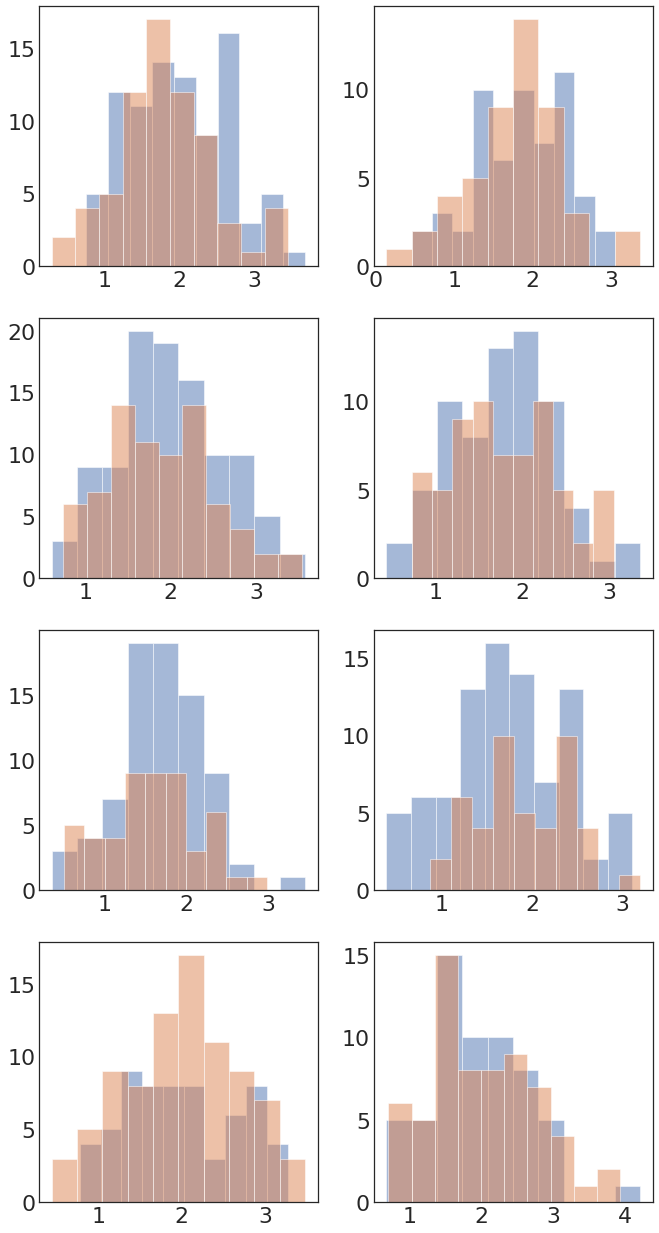

In [223]:
plotting_hist(res_df)

In [224]:
# plotting_hist(res_train_df)

Mean label = 0.4555256064690027


array([0.42458101, 0.43670886, 0.57432432, 0.39230769, 0.48888889,
       0.46226415, 0.52419355, 0.34586466])

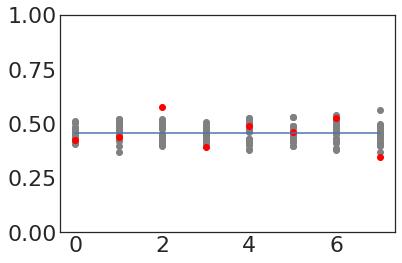

In [226]:
plot_predictions(prediction_df, transformed_df)

[179. 158. 148. 130. 135. 106. 124. 133.]


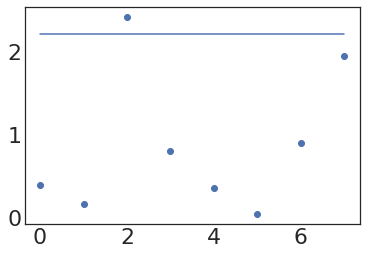

In [227]:
res_p = do_t_test(prediction_df, transformed_df, nb_components=4)

([0.5754189944134078, 0.5632911392405063, 0.5743243243243243, 0.6076923076923076, 0.5111111111111111, 0.5377358490566038, 0.5241935483870968, 0.6541353383458647], 281.0, 0.6541353383458647, 172, 283.4622456661049)


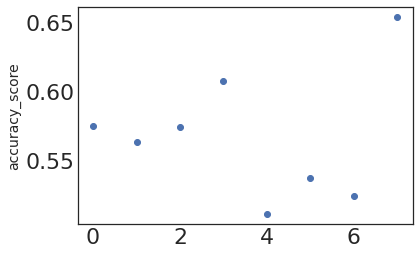

In [228]:
ret_nb_subjects = give_number_relevant_subjects_accuracy(prediction_df, transformed_df, res_p, nb_components=4)
print(ret_nb_subjects)
accuracy = ret_nb_subjects[0]

In [229]:
transformed_df.head()

,trans_0,trans_1,trans_2,trans_3
ID,,,,
100206,1.781894,0.000000,0.000000,0.0
100307,0.000000,-1.902838,0.000000,0.0
100408,0.000000,0.000000,-0.804931,0.0
100610,0.000000,0.890787,0.000000,0.0
101006,0.000000,0.000000,-1.660121,0.0


In [230]:
def plot_manhattan(prediction_df, transformed_df, accuracy, ax):
    labelsize=16
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    nb_components = 2*len(transformed_df.columns)
    res_p = do_t_test(prediction_df,
                      transformed_df,
                      show=False,
                      nb_components=nb_components)
    print(res_p)
    
    markerline, stemlines, baseline = \
        ax.stem(["Am", "Ap", "Bm", "Bp", "Cm", "Cp", "Dm", "Dp"],
              -np.log10(res_p),
              basefmt= 'C0',
              linefmt=':')
    plt.setp(markerline, 'color', 'black')
    plt.setp(stemlines, 'color', 'black')
    plt.setp(baseline, 'color', 'black')
    ax.plot(-np.log10(0.05/(nb_components))*np.ones(nb_components), c='black')
    ax.set_ylabel("-log$_{10}$(p)", labelpad=5.0)
    ax.set_xlabel("folding atoms", labelpad=10.0)
    ax2 = ax.twinx()
    ax2.xaxis.set_tick_params(labelsize = labelsize)
    ax2.yaxis.set_tick_params(labelsize = labelsize)
    ax2.plot(["Am", "Ap", "Bm", "Bp", "Cm", "Cp", "Dm", "Dp"],accuracy, c='blue')
    print(accuracy)
    ax2.set_ylim([0.,1.38])
    ax2.set_ylabel('accuracy', color='b', rotation=270, labelpad=25)
    ax2.set_yticks([0., 0.5, 1.0])
    ax2.spines['right'].set_color('blue')
    ax2.tick_params(axis='y', colors='blue')
    ax2.set_ylim(-0.08)


[179. 158. 148. 130. 135. 106. 124. 133.]
[0.41047052 0.68977149 0.00384238 0.15916873 0.43830801 0.9224615
 0.12638236 0.01146485]
[0.5754189944134078, 0.5632911392405063, 0.5743243243243243, 0.6076923076923076, 0.5111111111111111, 0.5377358490566038, 0.5241935483870968, 0.6541353383458647]


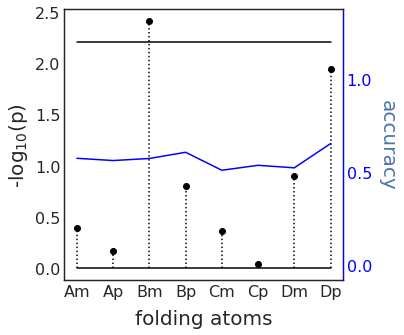

In [231]:
plt.rc('axes', labelsize=20) 
f, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_manhattan(prediction_df, transformed_df, accuracy, ax)
plt.show()

In [232]:
len(transformed_df)

1113

## Visualize umap

In [233]:
def compute_umap(df):
    # apply umap
    reducer = umap.UMAP()
    visual_embs = reducer.fit_transform(df)
    return visual_embs, reducer

In [234]:
def display_umaps_true_labels(visual_embs_train, reducer, test_df, prediction_df, verbose=False):
    if verbose:
        print("Test df:")
        print(test_df[:5])
        print("Prediction df:")
        print(prediction_df[:5])

    # apply umap
    if verbose:
        print("UMAP embeddings")
        print(visual_embs_train.shape)
        print(visual_embs_train[:5])
    visual_embs_test = reducer.transform(test_df)

    ## plot the graphs

    plt.figure()
    plt.scatter(visual_embs_train[:,0], visual_embs_train[:,1], c='green', alpha=0.1)

    # plot for true labels
    cmap = ['b', 'r']
    colors = [cmap[i] for i in prediction_df.label]

    plt.scatter(visual_embs_test[:,0], visual_embs_test[:,1], c=colors, alpha=0.6)
    plt.title("True labels")
    plt.show()
    
    plt.show()

    return pd.DataFrame(visual_embs_test, index=test_df.index.values)

In [235]:
test_df.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10
ID,,,,,,,,,,
100206,-4.212995,-6.091547,0.684881,-4.523183,-22.484660,-5.401763,7.193289,0.370416,-0.450990,-5.523917
100307,-11.381372,-0.285899,4.927240,-6.655341,-12.707940,2.209926,1.417612,8.749426,7.104039,-6.554468
100408,-4.779636,3.934073,4.724153,13.620280,0.672555,6.630541,-7.498281,-6.556976,11.008429,2.940424
100610,12.145811,-2.485926,-3.834113,-8.160859,1.870181,1.460826,12.370649,-0.535271,-0.761702,-1.108710
101006,12.997742,-5.642503,4.419471,4.485683,2.813661,13.278339,1.549487,0.472119,12.666689,-9.535495


In [236]:
visual_embs, reducer = compute_umap(test_df)

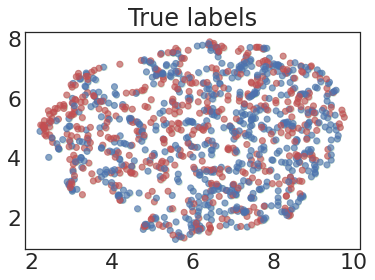

In [237]:
df_umap = display_umaps_true_labels(visual_embs, reducer, test_df, prediction_df, verbose=False)

In [238]:
transformed_df.head()

,trans_0,trans_1,trans_2,trans_3
ID,,,,
100206,1.781894,0.000000,0.000000,0.0
100307,0.000000,-1.902838,0.000000,0.0
100408,0.000000,0.000000,-0.804931,0.0
100610,0.000000,0.890787,0.000000,0.0
101006,0.000000,0.000000,-1.660121,0.0


In [239]:
transformed_df2 = transformed_df.copy()

In [240]:
transformed_df2["label"] = transformed_df.trans_1.apply(lambda x: 1 if x < 0. else 0)

In [241]:
transformed_df2.head()

,trans_0,trans_1,trans_2,trans_3,label
ID,,,,,
100206,1.781894,0.000000,0.000000,0.0,0
100307,0.000000,-1.902838,0.000000,0.0,1
100408,0.000000,0.000000,-0.804931,0.0,0
100610,0.000000,0.890787,0.000000,0.0,0
101006,0.000000,0.000000,-1.660121,0.0,0


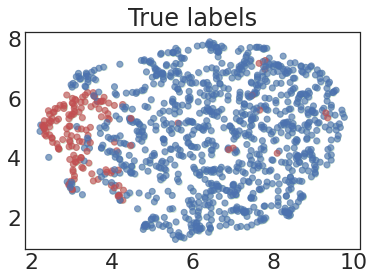

In [242]:
df_umap = display_umaps_true_labels(visual_embs, reducer, test_df, transformed_df2, verbose=False)

## Correspondance des sujets ACCpatterns

In [212]:
transformed_df2[transformed_df2.label==1].index

Int64Index([100307, 103818, 106016, 108020, 108222, 112516, 113417, 113922,
            114419, 115724,
            ...
            872764, 878877, 880157, 885975, 888678, 919966, 932554, 965367,
            978578, 983773],
           dtype='int64', name='ID', length=148)

In [167]:
transformed_df2[transformed_df2.label==1]

,trans_0,trans_1,trans_2,trans_3,label
ID,,,,,
101410,0.0,0.0,0.946302,0.0,1
102513,0.0,0.0,0.895911,0.0,1
104012,0.0,0.0,1.398829,0.0,1
107018,0.0,0.0,2.526485,0.0,1
108121,0.0,0.0,1.783298,0.0,1
...,...,...,...,...,...
901139,0.0,0.0,2.114108,0.0,1
969476,0.0,0.0,1.998873,0.0,1
979984,0.0,0.0,2.421519,0.0,1


In [168]:
prediction_df[transformed_df2.label==1]

,label,svm_0,svm_1,svm_2,svm_3,svm_4,svm_5,svm_6,svm_7,svm_8,...,svm_243,svm_244,svm_245,svm_246,svm_247,svm_248,svm_249,median_pred,mean_pred,average_model
Subject,,,,,,,,,,,,,,,,,,,,,
101410,1,0.465484,0.465990,0.475837,0.452778,0.473676,0.477245,0.485483,0.491343,0.436047,...,0.462629,0.479941,0.462286,0.453486,0.439044,0.471377,0.467853,0.461376,0.461288,0.493035
102513,1,0.439950,0.441843,0.426143,0.458428,0.429892,0.422298,0.409712,0.395555,0.480613,...,0.444746,0.416045,0.442849,0.457104,0.475262,0.427297,0.435213,0.445562,0.445714,0.399249
104012,0,0.461979,0.462677,0.468980,0.453548,0.467643,0.469653,0.474964,0.477969,0.442066,...,0.460178,0.471091,0.459621,0.453979,0.443945,0.465298,0.463365,0.459269,0.459111,0.479965
107018,0,0.460098,0.460898,0.465302,0.453962,0.464406,0.465581,0.469324,0.470799,0.445310,...,0.458862,0.466346,0.458190,0.454245,0.446585,0.462038,0.460957,0.457999,0.457949,0.472956
108121,0,0.472788,0.472893,0.490128,0.451177,0.486251,0.493068,0.507389,0.519174,0.423629,...,0.467733,0.500000,0.467836,0.452460,0.428913,0.484049,0.477207,0.466080,0.465848,0.520224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901139,0,0.428441,0.472155,0.493758,0.437823,0.439199,0.425265,0.451629,0.434630,0.476698,...,0.464649,0.444700,0.471361,0.471401,0.420030,0.472584,0.465437,0.460081,0.460122,0.445465
969476,1,0.500000,0.432947,0.403444,0.475720,0.477405,0.500000,0.461433,0.483874,0.425228,...,0.443839,0.469811,0.433107,0.434467,0.505612,0.436490,0.443343,0.449835,0.450071,0.467067
979984,0,0.399162,0.490205,0.535637,0.420888,0.422118,0.392811,0.447183,0.412760,0.500000,...,0.474186,0.433394,0.488972,0.488396,0.382983,0.489180,0.475566,0.464884,0.464910,0.435723


In [169]:
prediction_df[transformed_df2.trans_1 > 0.]

,label,svm_0,svm_1,svm_2,svm_3,svm_4,svm_5,svm_6,svm_7,svm_8,...,svm_243,svm_244,svm_245,svm_246,svm_247,svm_248,svm_249,median_pred,mean_pred,average_model
Subject,,,,,,,,,,,,,,,,,,,,,
100610,1,0.486163,0.485532,0.516259,0.448258,0.509257,0.521988,0.547311,0.569782,0.401361,...,0.477078,0.532051,0.478001,0.450588,0.410662,0.507244,0.494337,0.474828,0.474166,0.569665
101915,0,0.479962,0.479672,0.500000,0.449610,0.500000,0.508595,0.528842,0.546379,0.411605,...,0.472745,0.516466,0.473288,0.451455,0.419073,0.500000,0.486396,0.470772,0.470303,0.546801
105923,0,0.443432,0.445137,0.432866,0.457652,0.435829,0.429716,0.419852,0.408232,0.474447,...,0.447190,0.424637,0.445504,0.456607,0.470256,0.433269,0.439654,0.447860,0.447796,0.411693
106824,1,0.454961,0.456042,0.455272,0.455095,0.455577,0.454480,0.453959,0.451283,0.454218,...,0.455268,0.453415,0.454283,0.454970,0.453828,0.453146,0.454384,0.455018,0.454790,0.453870
109123,1,0.458626,0.459507,0.462427,0.454286,0.461876,0.462399,0.464917,0.465198,0.447855,...,0.457833,0.462639,0.457071,0.454452,0.448654,0.459490,0.459074,0.457032,0.457042,0.467480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907656,0,0.489999,0.435883,0.410054,0.472828,0.474490,0.493870,0.460689,0.480112,0.429063,...,0.445407,0.467899,0.435972,0.437235,0.500000,0.439197,0.445007,0.450617,0.450751,0.465423
930449,0,0.524347,0.416256,0.366704,0.492348,0.494160,0.532149,0.465708,0.505487,0.403524,...,0.434879,0.480802,0.416813,0.418718,0.543153,0.421082,0.433836,0.445355,0.446039,0.476517
933253,0,0.549722,0.401976,0.336567,0.506837,0.508757,0.560402,0.469434,0.524288,0.385121,...,0.427133,0.490387,0.402867,0.405224,0.575678,0.407868,0.425622,0.441466,0.442614,0.484759
